In [1]:
# imports
from connection import create_spotify_oauth, get_audio_features, get_token, get_tracks, \
    tracks_to_df, audio_features_to_df, get_artist_info, artist_info_to_df, get_album_info, \
        album_info_to_df, get_similar_artists

from itertools import chain

import json
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# token and authentication variables

sp_ouath = create_spotify_oauth()
token_info = get_token()

In [3]:
# getting playlist items

playlist_source = '7jfRuO7rW49RJnafrxsJeu' # playlist id for playlist

# playlists id's to play around with: 
### 5a4unKpRA7mYi2PAgKTuNW
### 7jfRuO7rW49RJnafrxsJeu
### 2YWkEfOW4TG0njIeLqFk4B
### 02dSgnwgoovYRH6RlptgDC
### 5EGXIeHfAZjPh1YeVLyG13
### 5tsD40JmH6fgIrguJdJ8tk
###

tracks = get_tracks(playlist_source, token_info) # parses Spotipy.playlist_items() to fetch playlist items
tracks_df = tracks_to_df(tracks) # extracts relevant features from messy list into a df

# drops duplicate songs based on track ID, this is useful if a song gets added from single and 
# album release; or in the case of deluxe versions of albums, etc.
tracks_df.drop_duplicates(subset=['track_id'], inplace=True)

# tracks_df = tracks_df.explode('artist_id') 

In [4]:
# getting tracks' features

tracks_features = []

for track in tracks_df['track_id']:
    track_af = get_audio_features(track, token_info) # parses Spotipy.audio_features() to fetch track features
    tracks_features.extend(track_af) # extends each track's features into the empty list init'd before
    
tracks_features_df = audio_features_to_df(tracks_features) # converts nested data from API call to simple df


In [5]:
# getting tracks' artists

tracks_artists = []

for artist_id in tracks_df['artist_id']:
    for i in artist_id: # since one track can have multiple artists, loop over the list of artists to pull data for each one
        artist_info = get_artist_info(i, token_info)
        tracks_artists.append(artist_info)

artists_df = artist_info_to_df(tracks_artists) # converts nested data to df

In [6]:
# getting tracks' albums

tracks_albums = []

for album_id in tracks_df['album_id']:
    album_info = get_album_info(album_id, token_info)
    tracks_albums.append(album_info)

albums_df = album_info_to_df(tracks_albums) # converts nested data to df

In [7]:
# initial tracks processing

# merging features df to track df
tracks_df.drop(['album_cover_640', 'album_cover_300', 'album_cover_64'], axis=1, inplace=True)
tracks_df = pd.merge(tracks_df, tracks_features_df, how='left')

# numerical features to plot to determine needed transformations
columns_to_plot = ['artist_number', 'song_popularity', 'danceability', 'energy',
                'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

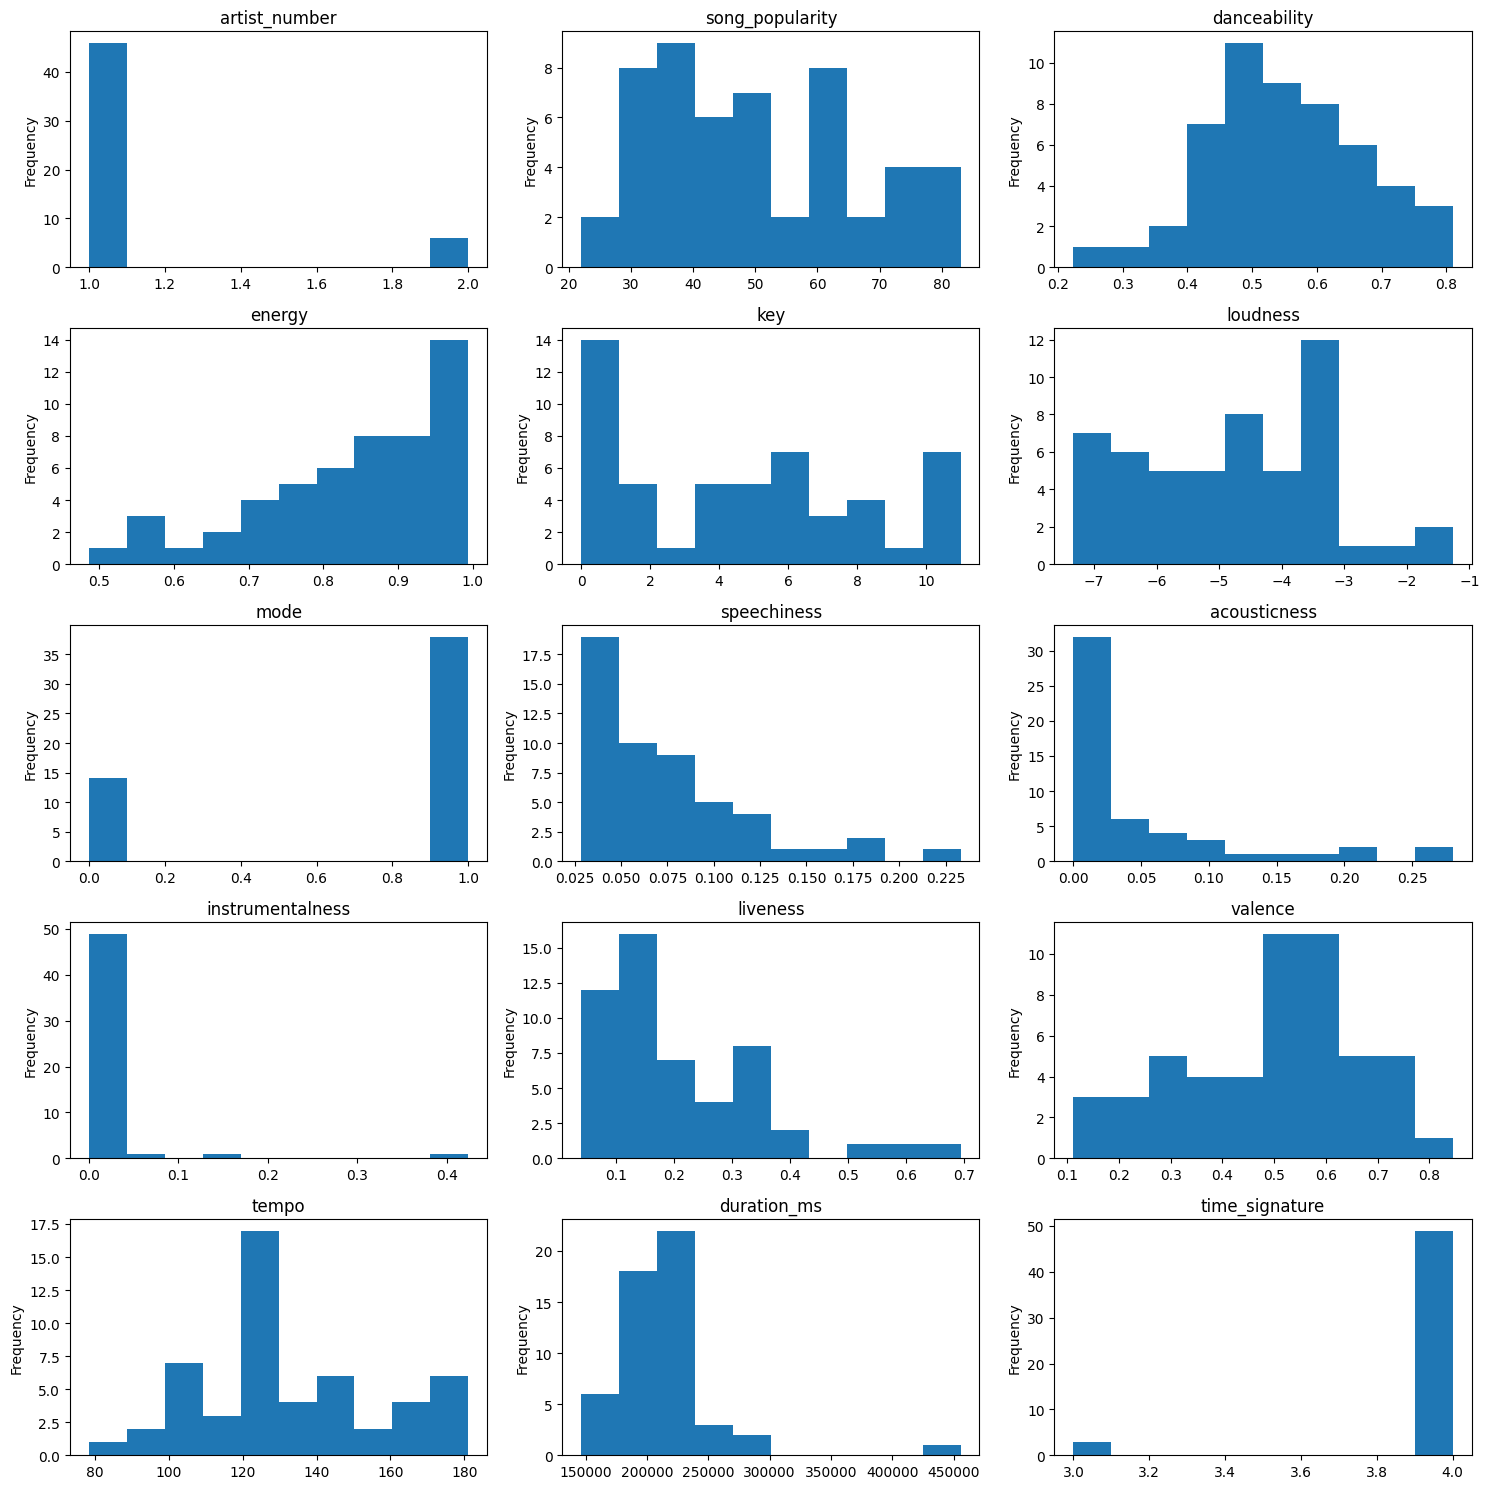

In [8]:
# histogram visualizations of numerical track_df features

num_cols = 3
num_rows = len(columns_to_plot) // num_cols + (len(columns_to_plot) % num_cols > 0) 

plt.figure(figsize=(15, 15))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(num_rows, num_cols, i)
    tracks_df[column].plot.hist()
    plt.title(column)

plt.tight_layout()

plt.show()

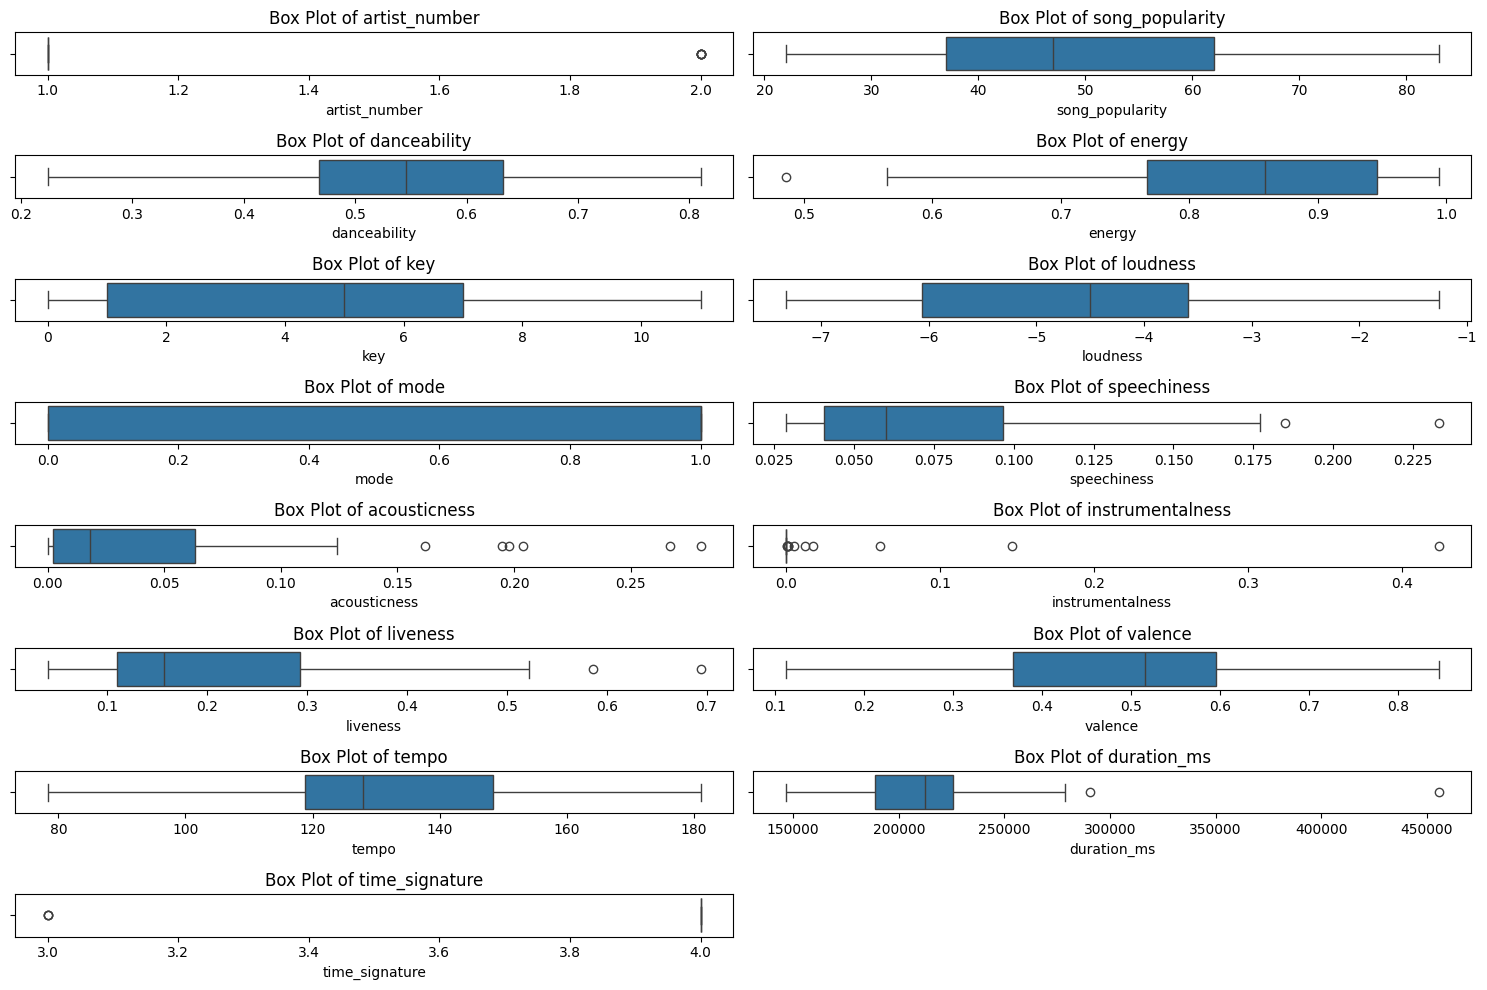

In [9]:
# boxplot visualizations of numerical track_df features
num_cols = 2
num_rows = len(columns_to_plot) // num_cols + (len(columns_to_plot) % num_cols > 0)

plt.figure(figsize=(15, 10))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=tracks_df[column])
    plt.title(f'Box Plot of {column}')

plt.tight_layout()

plt.show()

In [13]:
# more tracks processing

# exploding tracks df by artist ids
tracks_df = tracks_df.explode('artist_id')

In [14]:
# processing artist genres

# loop over artist df and check if any genres are missing

# lambda converts the columns into strings and strips of the exterior [] and '' using re, then splits the string 
# into a list based on ','
artists_df['artist_genres'] = artists_df['artist_genres'].apply(lambda x: re.sub(r"[\[\]']", '', str(x)).split(','))

# unnest the list of genres into seperate rows, rest of features are duplicated
artists_df = artists_df.explode('artist_genres')

# creates a copy of artist_df where there are no genres then drops those rows from the original df
artists_missing_genres = artists_df.loc[artists_df['artist_genres'] == ""].copy()
artists_df = artists_df[artists_df['artist_genres'] != '']

# check for any artists that have missing genres
if not artists_df.loc[artists_df['artist_genres'] == ''].empty:
    
    # iterates through the rows of the dataframe
    for index, artist in artists_missing_genres.iterrows():
        artist_id = artist['artist_id']
        similar_artists = get_similar_artists(artist_id, token_info) # API call
        
        # list comprehension that fetches the artist genres for every similar artist    
        genres_list = [similar_artist['genres'] for similar_artist in similar_artists if similar_artist['genres']]
        
    # convert the loop output to list
    flattened_genres = list(chain.from_iterable(genres_list))

    # converting to set so only unique values remain in list and adding it to the artists_missing_genres df
    artists_missing_genres.at[index, 'artist_genres'] = list(set(flattened_genres)) 

    artists_missing_genres = artists_missing_genres.explode('artist_genres')

    # if after imputation, there are still no genres, mark it off as not imputable
    artists_missing_genres['artist_genres'].replace('','genre not imputable', inplace=True)

    # concat the missing artist genres with the original df
    artists_df = pd.concat([artists_df, artists_missing_genres], ignore_index=False)

# dropping  duplicate records, this occurs if a playlist has multiple tracks from the same artist
artists_df.drop_duplicates(subset=['artist_id', 'artist_genres'], inplace=True)
artists_df.reset_index(inplace=True)

In [15]:
# creating master dataframe
print(type(tracks_df))
print(type(artists_df))
# merge tracks_df and artists_df on 'artist_id'
master_df = pd.merge(tracks_df, artists_df, on='artist_id', how='left')

# merge the result with album_df on 'album_id'
# master_df = pd.merge(master_df, albums_df, on='album_id', how='inner')


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,track_id,track_name,album_id,artist_id,artist_number,explicit,song_popularity,preview_url,danceability,energy,...,tempo,duration_ms,time_signature,level_0,index,artist_name,artist_followers,artist_popularity,artist_genres,artist_img_300
0,1ihEtdM3mmhRbe7cAIPKAx,Mr. Invisible,5tzquhU7KasVwjCbZDXQ24,4YygB8sfxuIcj2p0G9kpQ5,1,False,44,https://p.scdn.co/mp3-preview/d2c1e8c2c29b011c...,0.492,0.921,...,123.524,455547,4,0.0,0.0,Thank You Scientist,127780.0,38.0,progressive jazz fusion,https://i.scdn.co/image/ab6761610000e5eb730fd8...
1,6Gfz0ojUwlcQv2CUeaD2Pq,Complete You,7G984XgKrRusVBpuwtLbO2,03jrbNTeSKP9m161juhm0h,1,False,37,https://p.scdn.co/mp3-preview/9015b532f0c5e491...,0.531,0.909,...,115.006,256507,4,1.0,1.0,"Chunk! No, Captain Chunk!",162296.0,45.0,easycore,https://i.scdn.co/image/ab6761610000e5ebd77446...
2,6Gfz0ojUwlcQv2CUeaD2Pq,Complete You,7G984XgKrRusVBpuwtLbO2,03jrbNTeSKP9m161juhm0h,1,False,37,https://p.scdn.co/mp3-preview/9015b532f0c5e491...,0.531,0.909,...,115.006,256507,4,2.0,1.0,"Chunk! No, Captain Chunk!",162296.0,45.0,metalcore,https://i.scdn.co/image/ab6761610000e5ebd77446...
3,6Gfz0ojUwlcQv2CUeaD2Pq,Complete You,7G984XgKrRusVBpuwtLbO2,03jrbNTeSKP9m161juhm0h,1,False,37,https://p.scdn.co/mp3-preview/9015b532f0c5e491...,0.531,0.909,...,115.006,256507,4,3.0,1.0,"Chunk! No, Captain Chunk!",162296.0,45.0,pop punk,https://i.scdn.co/image/ab6761610000e5ebd77446...
4,5UZvBguQtkxJfgYrMZcRhe,Sunshine!,1wh6d2qvnS769wK1IEeXE1,6vwjIs0tbIiseJMR3pqwiL,1,False,44,None,0.470,0.857,...,170.107,198107,4,4.0,2.0,Beartooth,723023.0,62.0,melodic metalcore,https://i.scdn.co/image/ab6761610000e5eb448eb9...
5,5UZvBguQtkxJfgYrMZcRhe,Sunshine!,1wh6d2qvnS769wK1IEeXE1,6vwjIs0tbIiseJMR3pqwiL,1,False,44,None,0.470,0.857,...,170.107,198107,4,5.0,2.0,Beartooth,723023.0,62.0,metalcore,https://i.scdn.co/image/ab6761610000e5eb448eb9...
6,5UZvBguQtkxJfgYrMZcRhe,Sunshine!,1wh6d2qvnS769wK1IEeXE1,6vwjIs0tbIiseJMR3pqwiL,1,False,44,None,0.470,0.857,...,170.107,198107,4,6.0,2.0,Beartooth,723023.0,62.0,pop punk,https://i.scdn.co/image/ab6761610000e5eb448eb9...
7,5FNOz9n6kPl7oww9T2GbHo,Real,4B04Ir0bT4yyQ0tBM9i6Hj,13GH7wviJQ9gfZmr1pXHS4,1,True,44,https://p.scdn.co/mp3-preview/4e8c6a6f37a69fa0...,0.636,0.830,...,131.919,218182,4,7.0,3.0,Unprocessed,96243.0,46.0,djent,https://i.scdn.co/image/ab6761610000e5ebb311b9...
8,5sIU8SxnQzj08EGFvXrWz4,Picayune,4eofFWnX31BlShmFDqDy5S,5ktYe9ZQMyLivSJbjEEEXy,1,False,32,https://p.scdn.co/mp3-preview/6e9fadd0cf3a0916...,0.357,0.981,...,112.492,231798,3,8.0,4.0,Satyr,17862.0,22.0,progressive post-hardcore,https://i.scdn.co/image/ab6761610000e5eb1c3a67...
9,5sIU8SxnQzj08EGFvXrWz4,Picayune,4eofFWnX31BlShmFDqDy5S,5ktYe9ZQMyLivSJbjEEEXy,1,False,32,https://p.scdn.co/mp3-preview/6e9fadd0cf3a0916...,0.357,0.981,...,112.492,231798,3,9.0,4.0,Satyr,17862.0,22.0,swancore,https://i.scdn.co/image/ab6761610000e5eb1c3a67...


In [ ]:
## REUSABLE TESTING CODE 

# with open('all_tracks_albums.json', 'w') as outfile:
#     json.dump(all_tracks_albums, outfile, indent=4)

